In [1]:
#%load_ext tensorboard
import cv2 as cv
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import time
from PIL import Image, ImageDraw
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping
import btk
import dataset_generators as dgen

tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
plt.style.use(f"{os.environ['style']}")

In [ ]:
#Demo
""" tsx, tsy = dgen.gen_tseg_data(1, dgen.trainfonts, dgen.xtseg, True)
tsx, tsy = btk.zshuffle(tsx, tsy)
for i, x in enumerate(tsx):
    display(Image.fromarray(x))
    display(tsy[i]) """

""" num = 560000
for i, x in enumerate(trainx[num:num + 10]):
    display(Image.fromarray(x))
    display(trainy[i + num]) """

In [2]:
""" trainx_1, trainy_1, valx_1, valy_1 = btk.depickler('trainx-1644993728', 'trainy-1644993728', 'valx-1644993728', 'valy-1644993728', 'ocr')
trainx_2, trainy_2, valx_2, valy_2 = btk.depickler('trainx-1644994651', 'trainy-1644994651', 'valx-1644994651', 'valy-1644994651', 'ocr')
trainx_3, trainy_3, valx_3, valy_3 = btk.depickler('trainx-1644994195', 'trainy-1644994195', 'valx-1644994195', 'valy-1644994195', 'ocr')
trainx_4, trainy_4, valx_4, valy_4 = btk.depickler('trainx-1644995253', 'trainy-1644995253', 'valx-1644995253', 'valy-1644995253', 'ocr')
trainx_5, trainy_5, valx_5, valy_5 = btk.depickler('trainx-1644998311', 'trainy-1644998311', 'valx-1644998311', 'valy-1644998311', 'ocr') """

""" trainx, trainy = dgen.gen_tseg_data(14000, dgen.trainfonts, dgen.xtseg, True)
valx, valy = dgen.gen_tseg_data(4620, dgen.evalfonts, dgen.xtseg, False)
trainx, trainy = btk.zshuffle(trainx, trainy)
valx, valy = btk.zshuffle(valx, valy)
btk.pickle_set(trainx, trainy, valx, valy, 'ocr') """

" trainx, trainy = dgen.character_spaces(14000, dgen.trainfonts, dgen.xtseg, True)\nvalx, valy = dgen.character_spaces(4620, dgen.evalfonts, dgen.xtseg, False)\ntrainx, trainy = btk.zshuffle(trainx, trainy)\nvalx, valy = btk.zshuffle(valx, valy)\nbtk.pickle_set(trainx, trainy, valx, valy, 'ocr') "

In [ ]:
def model_init():
    inp = keras.Input(shape=(64, 12, 1))
    x = layers.Rescaling(1.0/255)(inp)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization(axis=3)(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization(axis=3)(x)
    for features in [128, 256]:
        res = x
        x = layers.Conv2D(features, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization(axis=3)(x)
        x = layers.Conv2D(features, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization(axis=3)(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Dropout(0.1)(x)
        res = layers.Conv2D(features, 1, strides=2, activation='relu')(res)
        x = layers.add([x, res])
        x = layers.BatchNormalization(axis=3)(x)

    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization(axis=3)(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalMaxPooling2D()(x)
    x = layers.Dropout(0.3678)(x)
    outp = layers.Dense(1, activation='sigmoid')(x)

    opti = keras.optimizers.Adam(learning_rate=0.001)
    mod = keras.Model(inp, outp, name='tseg')
    mod.compile(optimizer=opti, loss='binary_crossentropy', metrics=['accuracy'])
    return mod

tseg = model_init()
tseg.summary()

In [11]:
tnum = 0
measure = 'accuracy'
imgent = btk.DataGen(trainx_1, trainy_1, 192)
imgenv = btk.DataGen(valx_1, valy_1, 64)

for itr in range(2):
    log_dir = f"tblogs/segmentation/5/tseg1/"
    tbcall = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    tnum += 1
    tseg = model_init()
    tstart = time.time()
    history = tseg.fit(
        x = imgent,
        validation_data=imgenv,
        epochs=32,
        steps_per_epoch=32,
        validation_steps=32,
        callbacks=[tbcall],
        verbose=0
    )
    tstop = time.time()
    ttime = tstop - tstart
    if itr == 0:
        old_hist = history.history
        otime = ttime
    if itr == 1:
        btk.mlstats(history.history, ttime, measure, old_hist, otime)

Score: 0.9088313938002498
Best VAccuracy: 0.951904296875
Best VLoss: 0.1277378425002098
Last 7 Avg VAccuracy: 0.9427664620535714
Last 7 Avg VLoss: 0.15034601730959757
Training time: 131.35756528377533
Samples per second: 1995.841612852403


In [ ]:
log_dir = "tblogs/segmentation/4/tseg12/"
measure = 'accuracy'
best_score = 0.9

for i in range(5):
    if i in [0, 5, 10]:
        imgent = btk.DataGen(trainx_1, trainy_1, 192)
        imgenv = btk.DataGen(valx_1, valy_1, 64)
    elif i in [1, 6]:
        imgent = btk.DataGen(trainx_2, trainy_2, 192)
        imgenv = btk.DataGen(valx_2, valy_2, 64)
    elif i in [2, 7]:
        imgent = btk.DataGen(trainx_3, trainy_3, 192)
        imgenv = btk.DataGen(valx_3, valy_3, 64)
    elif i in [3, 8]:
        imgent = btk.DataGen(trainx_4, trainy_4, 192)
        imgenv = btk.DataGen(valx_4, valy_4, 64)
    elif i in [4, 9]:
        imgent = btk.DataGen(trainx_4, trainy_4, 192)
        imgenv = btk.DataGen(valx_4, valy_4, 64)
    tbcall = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    estop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=32, restore_best_weights=True)
    calls = [tbcall]
    if i == 10:
        calls = [estop, tbcall]
    history = tseg.fit(
        x = imgent,
        validation_data=imgenv,
        epochs=100,
        steps_per_epoch=28,
        validation_steps=28,
        callbacks=calls,
        verbose=0
    )
    score = (
            max(history.history.get(f"val_{measure}"))
            + (2.7182818**-(min(history.history.get("val_loss"))))
            + (sum(history.history.get(f"val_{measure}")[-7:]) / 7)
            + (sum(2.7182818**-(np.array(history.history.get("val_loss")[-7:]))) / 7)
            ) / 4
    display(score)
    if score > best_score:
        tseg.save('models\\tseg-1')
        display(f'Model Updated. Evaluation: {score} beating {best_score}')
        display(f'Best VAccuracy: {max(history.history.get(f"val_{measure}"))}   Best VLoss: {min(history.history.get("val_loss"))}')
        display(f'Latest Runs Avg VAccuracy: {sum(history.history.get(f"val_{measure}")[-7:]) / 7}   Latest Runs Avg VLoss: {sum(history.history.get("val_loss")[-7:]) / 7}')
        best_score = score


In [3]:
tseg = tf.keras.models.load_model('models\\tseg-1')
#tseg.save('models\\tseg-1')

In [4]:

def draw_sep(img, seps):
    img = Image.fromarray(img)
    ymax = img.size[1]
    for x in seps:
        ImageDraw.Draw(img).line([x, 0, x, ymax], 125, 1)
    return img

def spc_detect(slices, sens):
    preds = np.array([x[0] for x in tseg.predict(slices)])
    preds[preds < sens] = 0
    return preds

def extract_rows(img):
    iar = np.array(img)
    blur_coef_1, blur_coef_2 = 5, 1
    if img.size > 49152:
        blur_coef_1 = btk.odder(round(11 * (img.size /  32768) ** 0.5))
        blur_coef_2 = btk.odder(round((img.size /  32768) ** 0.5))
    bgcheck, _ = np.histogram(img.flatten(), 255, (0, 255))
    pix_mode = bgcheck.argmax()
    if bgcheck.argmax() > 127:
        img = np.invert(img)
        pix_mode = 255 - pix_mode
    img = cv.Canny(img, pix_mode + 35, 200, apertureSize=3)
    img = cv.GaussianBlur(img, (blur_coef_1, blur_coef_2), blur_coef_1)
    img[img > 0] = 255
    conts = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0]
    #im = cv.drawContours(iar.copy(), conts, -1, (0,255,0), 2)
    #display(Image.fromarray(im))
    bounds = []
    for x in conts:
        xset = [y[0][0] for y in x]
        yset = [y[0][1] for y in x]
        bounds.append((min(yset), max(yset), min(xset), max(xset)))
        bounds = [x for x in bounds if (x[1] - x[0]) * (x[3] - x[2]) > 256 and x[1] - x[0] > 6 and (x[1] - x[0] + 4) < (x[3] - x[2])]
    for x in bounds.copy():
        for y in bounds.copy():
            if x[0] > y[0] and x[1] < y[1] and x[2] > y[2] and x[3] < y[3]:
                try:
                    bounds.remove(x)
                except: ValueError
    bounds = [x for x in bounds if (x[1] - x[0]) * (x[3] - x[2]) > 256 and x[1] - x[0] > 6 and (x[1] - x[0] + 4) < (x[3] - x[2])]
    bounds = expand_coordinates(bounds, iar.shape, (0.08, 0.03))
    return [iar[x[0]:x[1], x[2]:x[3]] for x in bounds], bounds

def chopper(img, divs):
    img = np.array(img)
    if divs[-1] - len(divs) >= 32:
        divs.append(divs[-1] + 32)
    else:
        divs.append(len(img[0]) - 1)
    cpack = []
    for i, x in enumerate(divs):
        if i == len(divs) - 1:
            break
        if divs[i + 1] - x >= 4:
            cpack.append(Image.fromarray(img[:, x:divs[i + 1]]))
    return cpack

def split_letters(img, dims, sens):
    img = btk.force_dim(img, dims[0], 1)
    split = [img, np.invert(img)]
    temp = []
    for x in split:
        slices = btk.img_slicer(x, dims, 1, 'v')
        temp.append(np.array(spc_detect(slices, sens / 3)))
    preds = (temp[0] + temp[1]) / 2
    display(preds)
    preds[preds < sens] = 0
    idx = btk.gen_index(img.shape, (64, 16), 1, 'v')
    crits = btk.criticals(btk.smooth_avg(btk.smooth_avg(preds)), idx)
    crits = [int(btk.halfpoint(x[0][0], x[0][1])) for x in crits if x[1] == 'max']
    crits = grouper(crits)
    #img = draw_sep(img, crits)
    #display(img.resize((img.size[0] * 2, img.size[1] * 2)))
    return chopper(img, crits)

def grouper(inp: list, min=1, dist=3):
    inp.sort()
    last = 0
    vals = []
    confirmed = []
    for x in inp:
        if x - last >= dist:
            vals.append(last)
            if len(vals) >= min:
                confirmed.append(round(sum(vals) / len(vals)))
            vals = []
            last = x
        else:
            vals.append(last)
            last = x
    confirmed.append(last)
    return confirmed

def expand_coordinates(bounds: tuple[int, ...], idims: tuple[int, int], stretch: tuple[float, float] = (0.085, 0.085)) -> tuple[int, ...]:
    """Expands coordinate inputs slightly to account for imprecise text detection"""
    for i, x in enumerate(bounds):
        ygap = (x[1] - x[0]) * stretch[0]
        xgap = (x[3] - x[2]) * stretch[1]
        bounds[i] = [round(x[0] - ygap), round(x[1] + ygap), round(x[2] - xgap), round(x[3] + xgap)]
    for i, x in enumerate(bounds):
        if x[0] < 0:
            bounds[i][0] = 0
        if x[1] > idims[0]:
            bounds[i][1] = idims[0]
        if x[2] < 0:
            bounds[i][2] = 0
        if x[3] > idims[1]:
            bounds[i][3] = idims[1]
    return bounds

def contour_bounds(img):
    conts = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0]
    #im = cv.drawContours(iar.copy(), conts, -1, (0,255,0), 2)
    #display(Image.fromarray(im))
    bounds = []
    for x in conts:
        xset = [y[0][0] for y in x]
        yset = [y[0][1] for y in x]
        bounds.append((min(yset), max(yset), min(xset), max(xset)))
        bounds = [x for x in bounds if (x[1] - x[0]) * (x[3] - x[2]) > 256 and x[1] - x[0] > 6]
    for x in bounds.copy():
        for y in bounds.copy():
            if x[0] > y[0] and x[1] < y[1] and x[2] > y[2] and x[3] < y[3]:
                try:
                    bounds.remove(x)
                except: ValueError
    return bounds


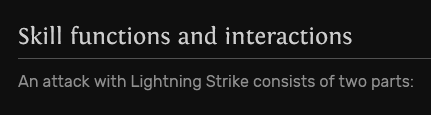

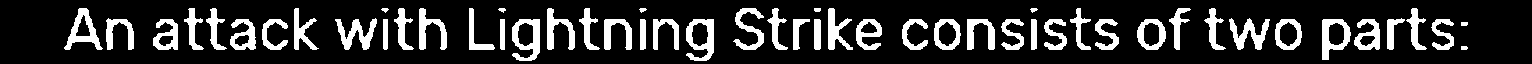

array([  62.,  103.,  135.,  138.,  149.,  182.,  205.,  227.,  258.,
        290.,  320.,  334.,  378.,  392.,  415.,  451.,  464.,  496.,
        508.,  542.,  577.,  600.,  635.,  649.,  681.,  716.,  731.,
        766.,  789.,  810.,  824.,  853.,  883.,  899.,  930.,  963.,
        997., 1026., 1040., 1068., 1092., 1121., 1134., 1168., 1193.,
       1203., 1226., 1272., 1303., 1317., 1352., 1382., 1406., 1428.,
       1455., 1470.])

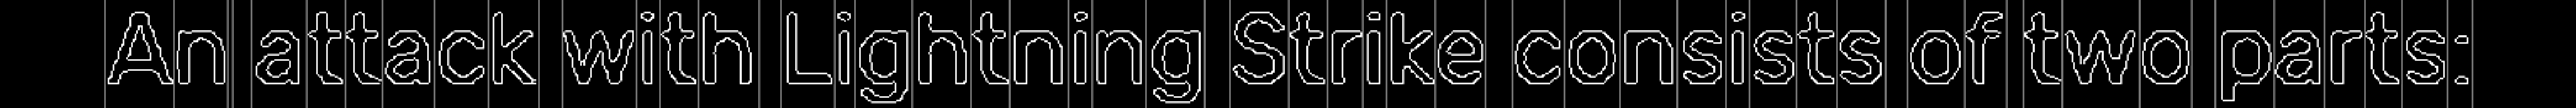

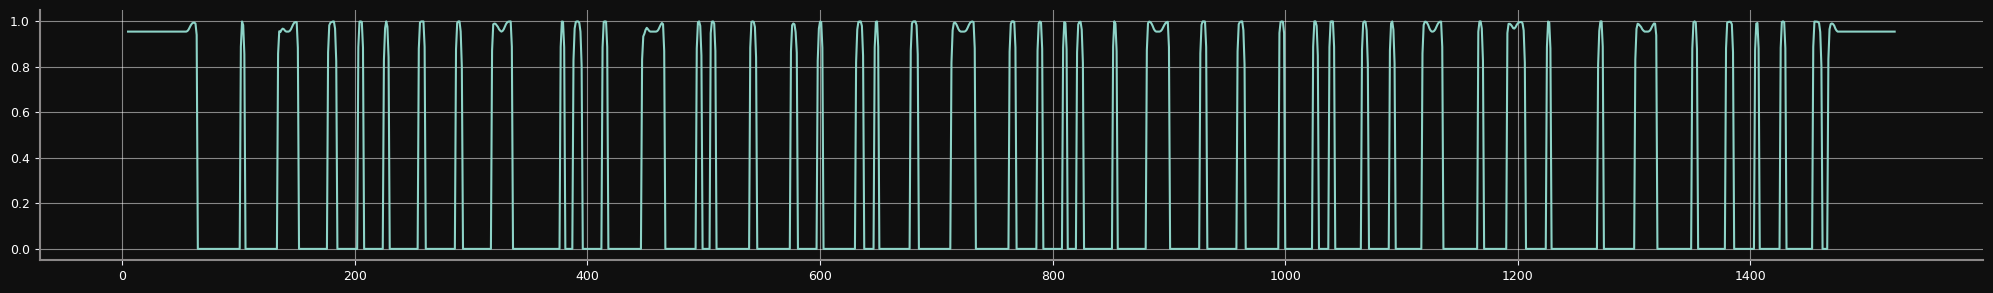

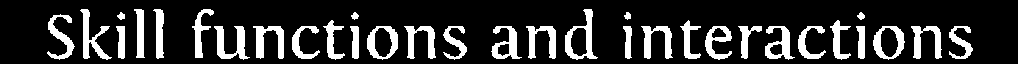

array([ 44.,  77., 113., 131., 146., 151., 165., 190., 213., 251., 287.,
       322., 347., 363., 401., 437., 439., 468., 489., 524., 560., 599.,
       601., 621., 635., 639., 674., 678., 702., 735., 762., 795., 828.,
       853., 870., 908., 944., 974.])

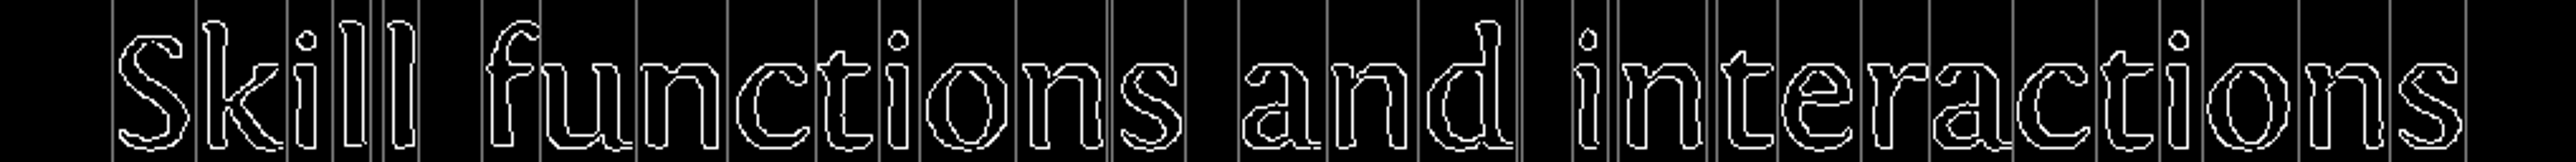

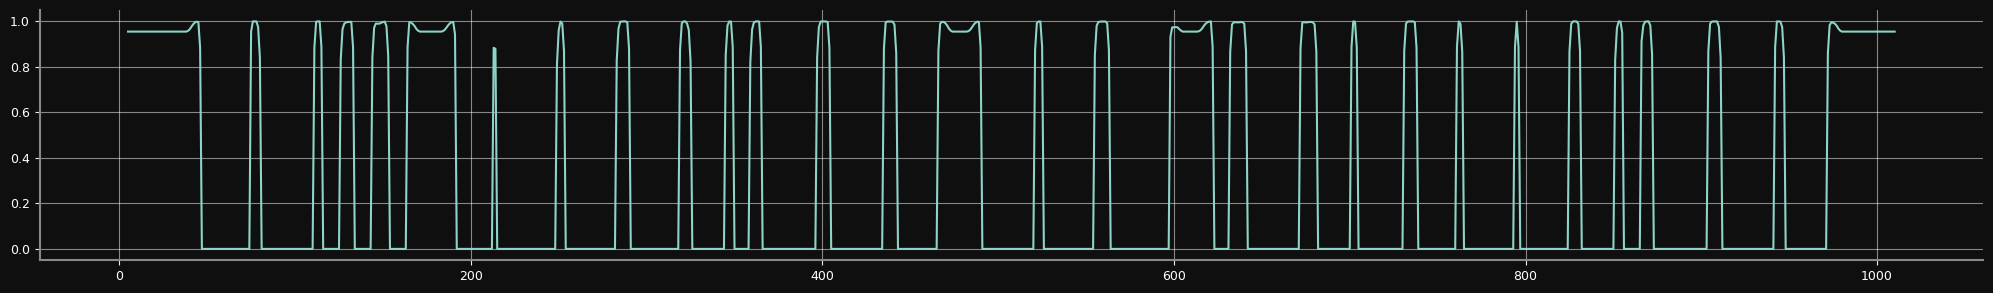

In [8]:
with Image.open("testimgs\\t16.png") as f:
    iar = btk.grey_np(f)[50:250, :]
display(Image.fromarray(iar))
im = Image.fromarray(iar)
rows, row_coords = extract_rows(iar)

for row in rows:
    row = btk.force_dim(row, 64, 1)
    row = btk.sharpen(row)
    _, row = cv.threshold(row, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    row = row / 255
    row = cv.erode(row, (3, 3), 125, iterations=1)
    row = row.astype('uint8') * 255
    display(Image.fromarray(row))
    row = cv.Canny(row, 50, 200, apertureSize=3)
    slices = btk.img_slicer(row, (64, 12), 1, 'v')
    idx = btk.gen_index(row.shape, (64, 12), 1, 'v')
    preds = spc_detect(slices, 0.5)
    preds = np.array(btk.smooth_avg(btk.smooth_avg(preds)))
    preds[preds < 0.8] = 0
    crits = btk.criticals(preds, idx)
    crits = np.array([btk.halfpoint(x[0][0], x[0][1]) for x in crits if x[1] == 'max'])
    display(crits)

    im = draw_sep(row, crits)
    display(im.resize((im.size[0] * 3, im.size[1] * 3)))
    fig = plt.figure()
    fig.set_size_inches(20, 3)
    ax = plt.axes()
    plt.plot(range(5, len(preds) + 5), preds)
    #plt.vlines(crits, 0, 1, colors='r')
    plt.show()
